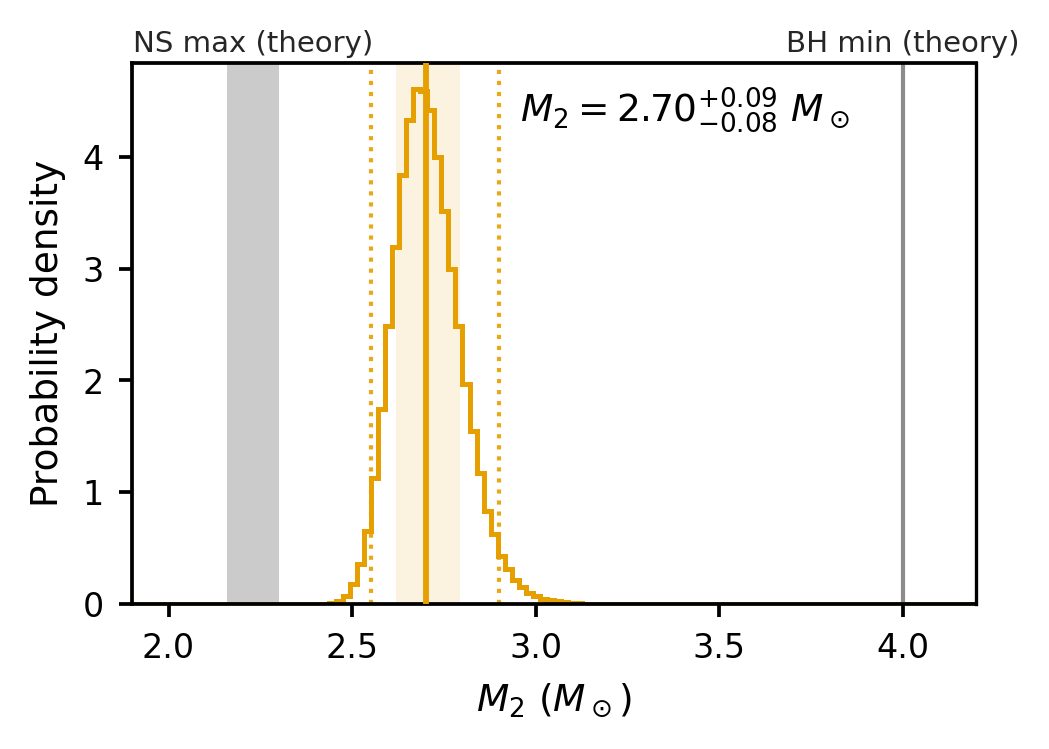

In [2]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Monte Carlo inference of companion mass (M2) from (P, a1*sin i, e, i, M1),
and publication-style posterior figure.

- All scientific values/priors are exactly as provided.
- Asymmetric uncertainties are sampled with a split-normal scheme.
- Outputs:
    * samples.csv                (thinned posterior samples)
    * M2_posterior_nature.png    (posterior histogram figure)

Dependencies: numpy, pandas, matplotlib
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.transforms import blended_transform_factory

# -------------------------------
# RNG
# -------------------------------
rng = np.random.default_rng(42)

# ===================== Inputs: asymmetric uncertainties (kept EXACTLY) =====================
P_mu, P_err = 960.137, (2.072, 2.072)                  # days
a1sini_mu, a1sini_err = 902.695, (5.169, 5.169)        # light-seconds
e_mu, e_err = 0.096, (0.013, 0.013)

i_mu_deg, i_err = 72.0, (3.0, 2.9)                     # deg
M1_mu,  M1_err  = 1.744, (0.05, 0.05)                  # Msun

# ===================== Physical constants (kept EXACTLY) =====================
G    = 6.67430e-11          # m^3 kg^-1 s^-2
Msun = 1.98847e30           # kg
day  = 86400.0              # s
c    = 299792458.0          # m/s

# ===================== Split-normal sampler (as provided) =====================
def split_normal(rng, mu, err_minus, err_plus, size):
    """
    Two-piece normal: left N(mu, σ_-), right N(mu, σ_+).
    Mixing proportion proportional to σ_- and σ_+.
    """
    err_minus = float(err_minus)
    err_plus  = float(err_plus)
    p_left = err_minus / (err_minus + err_plus)
    u = rng.random(size)
    n_left  = np.sum(u < p_left)
    n_right = size - n_left
    out = np.empty(size, dtype=float)
    if n_left > 0:
        out[u < p_left] = rng.normal(mu, err_minus, size=n_left)
    if n_right > 0:
        out[u >= p_left] = rng.normal(mu, err_plus,  size=n_right)
    return out

# ===================== Monte Carlo sampling (kept EXACTLY) =====================
N = 200000

# P, e, a1sini with asymmetric uncertainties
P_days   = split_normal(rng, P_mu,   *P_err,   size=N)
P        = P_days * day
e        = np.clip(split_normal(rng, e_mu, *e_err, size=N), 0.0, 0.99)
a1sini_ls = split_normal(rng, a1sini_mu, *a1sini_err, size=N)
a1sini_m  = a1sini_ls * c

# Inclination and primary mass with asymmetric uncertainties
i_deg = np.clip(split_normal(rng, i_mu_deg, *i_err, size=N), 0.1, 179.9)
i_rad = np.deg2rad(i_deg)
sin_i = np.sin(i_rad)

M1 = split_normal(rng, M1_mu, *M1_err, size=N) * Msun
M1 = np.clip(M1, 0.3*Msun, 5.0*Msun)

# ===================== From a1*sin(i) to K1 (kept EXACTLY) =====================
# a1*sin i = (K1 * P * sqrt(1 - e^2)) / (2π)
K1 = (2.0*np.pi * a1sini_m) / (P * np.sqrt(1.0 - e**2))   # m/s
K1_kms = K1 / 1000.0

# Mass function f(M)
# f(M) = (K1^3 P (1 - e^2)^(3/2)) / (2πG)
fM_SI = (K1**3 * P * (1.0 - e**2)**1.5) / (2.0*np.pi*G)   # kg
fM = fM_SI / Msun                                         # Msun

# ===================== Solve M2 from f(M), M1, i (kept EXACTLY) =====================
# f = (M2^3 sin^3 i) / (M1 + M2)^2
def solve_M2(f_Msun, M1_val, s):
    # Vectorized Newton solver
    f_kg = f_Msun * Msun
    x0 = ((f_Msun * (M1_val/Msun)**2)**(1/3.0)) / np.maximum(s, 1e-6)
    M2 = np.clip(x0 * Msun, 1e-6*Msun, 50*Msun)
    for _ in range(30):
        num = (M2**3) * (s**3)
        den = (M1_val + M2)**2
        F  = num/den - f_kg
        dF = ( (3*M2**2)*(s**3)/den ) - ( num * 2*(M1_val+M2) / (den**2) )
        step = F / np.where(np.abs(dF) > 0, dF, np.inf)
        M2_new = np.clip(M2 - step, 1e-6*Msun, 50*Msun)
        if np.all(np.abs(M2_new - M2) < 1e-9*Msun):
            M2 = M2_new
            break
        M2 = M2_new
    return M2

M2 = solve_M2(fM, M1, sin_i)
M2_Msun = M2 / Msun

# ===================== Summary table (kept EXACTLY) =====================
def q(a):
    return np.quantile(a, [0.16, 0.50, 0.84, 0.025, 0.975])

def summarize(name, arr):
    q16, q50, q84, q025, q975 = q(arr)
    return {
        "Parameter": name,
        "median": q50,
        "q16": q16, "q84": q84, "q2.5": q025, "q97.5": q975,
        "err_minus_68": q50 - q16,
        "err_plus_68":  q84 - q50,
        "err_minus_95": q50 - q025,
        "err_plus_95":  q975 - q50,
    }

rows = [
    summarize("M2 [Msun]", M2_Msun),
    summarize("K1 [km/s]", K1_kms),
    summarize("f(M) [Msun]", fM),
    summarize("i [deg]", i_deg),
    summarize("M1 [Msun]", M1/Msun),
    summarize("P [days]", P_days),
    summarize("e", e),
    summarize("a1*sin(i) [light-sec]", a1sini_ls),
]

summary_df = pd.DataFrame(rows, columns=[
    "Parameter","median","q16","q84","q2.5","q97.5",
    "err_minus_68","err_plus_68","err_minus_95","err_plus_95"
])

# ===================== Thinned samples saved to CSV (kept EXACTLY) =====================
samples_df = pd.DataFrame({
    "M2_Msun": M2_Msun[::50],
    "M1_Msun": (M1/Msun)[::50],
    "i_deg":   i_deg[::50],
    "fM_Msun": fM[::50],
    "K1_kms":  K1_kms[::50],
    "P_days":  P_days[::50],
    "e":       e[::50],
    "a1sini_lightsec": a1sini_ls[::50],
})
samples_df.to_csv("samples.csv", index=False)

# ===================== Posterior plot (kept EXACTLY) =====================
# 1) inputs: M2 posterior
M2_plot = np.asarray(M2_Msun, dtype=float)
M2_plot = M2_plot[np.isfinite(M2_plot)]
assert M2_plot.size > 1, "M2 samples are empty."

# 2) stats (equal-tail)
med = np.median(M2_plot)
q16, q84   = np.quantile(M2_plot, [0.16, 0.84])
q025, q975 = np.quantile(M2_plot, [0.025, 0.975])
err_minus, err_plus = med - q16, q84 - med

# 3) constants (kept EXACTLY)
NS_obs_mu, NS_obs_sig = 2.08, 0.07     # observed max NS mass (not drawn by default)
NS_obs_lo, NS_obs_hi = NS_obs_mu - NS_obs_sig, NS_obs_mu + NS_obs_sig
NS_theo_lo, NS_theo_hi = 2.16, 2.30    # theoretical max NS mass range
BH_theo_min = 4.0                      # theoretical BH minimum (illustrative)
x_min, x_max = 1.9, 4.2                # x-range

# 4) FD bin rule
def fd_bins(x, bmin=30, bmax=120):
    q25, q75 = np.percentile(x, [25, 75])
    iqr = q75 - q25
    n = x.size
    if iqr <= 0 or n < 2:
        return 50
    h = 2 * iqr * n ** (-1/3)
    bins = int(np.ceil((x.max() - x.min()) / h))
    return max(bmin, min(bins, bmax))

# 5) figure
col = "#E69F00"  # Okabe–Ito orange
fig, ax = plt.subplots(figsize=(3.6, 2.6), dpi=300)

# constraint bands/lines (background)
ax.axvspan(NS_theo_lo, NS_theo_hi, color='0.75', alpha=0.8, lw=0, zorder=0)  # theory NS max (light gray)
# ax.axvspan(NS_obs_lo,  NS_obs_hi,  color='0.75', alpha=0.8, lw=0, zorder=0)  # observed NS max (disabled)
ax.axvline(BH_theo_min, color='0.55', lw=1.0, zorder=0.8)                      # BH lower limit

# main histogram (range cropped to [x_min, x_max])
bins = fd_bins(M2_plot)
ax.hist(M2_plot, bins=bins, range=(x_min, x_max), density=True,
        histtype='step', linewidth=1.2, color=col, zorder=2)

# 68% band and median
ax.axvspan(q16, q84, color=col, alpha=0.12, lw=0, zorder=1.6)
ax.axvline(med, color=col, lw=1.4, zorder=3)

# 95% ticked lines
ax.axvline(q025, color=col, lw=1.0, ls=':', alpha=0.9, zorder=2.5)
ax.axvline(q975, color=col, lw=1.0, ls=':', alpha=0.9, zorder=2.5)

# axes
ax.set_xlabel(r"$M_2\ (M_\odot)$", fontsize=9)
ax.set_ylabel("Probability density", fontsize=9)
ax.set_xlim(x_min, x_max)

# annotation (top-right)
ax.text(0.85, 0.96,
        rf"$M_2={med:.2f}^{{+{err_plus:.2f}}}_{{-{err_minus:.2f}}}\ M_\odot$",
        transform=ax.transAxes, ha='right', va='top', fontsize=9)

# spines/ticks
ax.spines['top'].set_visible(True)
ax.spines['right'].set_visible(True)
for s in ('bottom', 'left', 'top'):
    ax.spines[s].set_linewidth(0.9)
ax.tick_params(axis='both', labelsize=8, length=3.2, width=0.9)

# constraint labels above axis
tx = blended_transform_factory(ax.transData, ax.transAxes)
# ax.text(NS_obs_mu, 1.01, "NS max (obs.)", ha='center', va='bottom',
#         transform=tx, fontsize=7, color='0.25', clip_on=False)
ax.text((NS_theo_lo+NS_theo_hi)/2, 1.01, "NS max (theory)", ha='center', va='bottom',
        transform=tx, fontsize=7, color='0.15', clip_on=False)
ax.text(BH_theo_min, 1.01, "BH min (theory)", ha='center', va='bottom',
        transform=tx, fontsize=7, color='0.15', clip_on=False)

plt.tight_layout()
plt.savefig("figure2.png", dpi=600, bbox_inches="tight")
plt.show()